In [1]:
from scipy.ndimage.filters import convolve
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import cv2
import itertools
import math
from typing import Tuple, List
import canny_edge_detector as canny
from skimage.color import rgb2gray
from PIL import Image
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from log_gabor import normalization_to_template
#import hamming distance from scipy
from scipy.spatial.distance import hamming


In [2]:
def showHist(img):
    # An "np.int64erface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


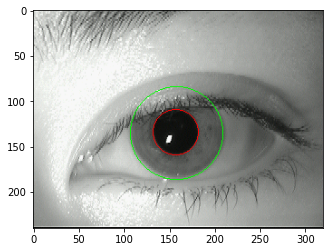

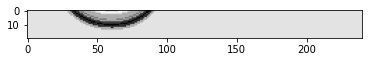

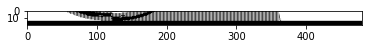

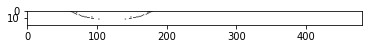

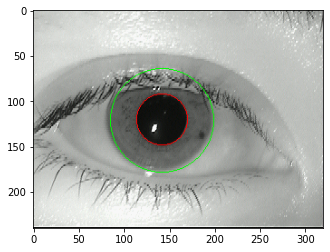

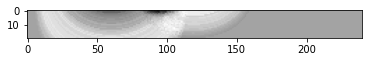

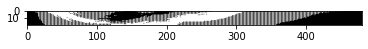

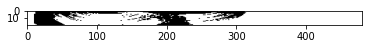

0.08333333333333333


In [3]:

def normalize(image, x_iris, y_iris, r_iris, x_pupil, y_pupil, r_pupil,
			  radpixels=20, angulardiv=240):
	"""
	Description:
		Normalize iris region by unwraping the circular region into a rectangular
		block of constant dimensions.
	Input:
		image		- Input iris image.
		x_iris		- x-coordinate of the circle defining the iris boundary.
		y_iris		- y-coordinate of the circle defining the iris boundary.
		r_iris		- Radius of the circle defining the iris boundary.
		x_pupil		- x-coordinate of the circle defining the pupil boundary.
		y_pupil		- y-coordinate of the circle defining the pupil boundary.
		r_pupil		- Radius of the circle defining the pupil boundary.
		radpixels	- Radial resolution (vertical dimension).
		angulardiv	- Angular resolution (horizontal dimension).
	Output:
		polar_array	- Normalized form of the iris region.
		polar_noise	- Normalized form of the noise region.
	"""
	radiuspixels = radpixels + 2
	angledivisions = angulardiv-1

	r = np.arange(radiuspixels)
	theta = np.linspace(0, 2*np.pi, angledivisions+1)

	# Calculate displacement of pupil center from the iris center
	ox = x_pupil - x_iris
	oy = y_pupil - y_iris

	if ox <= 0:
		sgn = -1
	elif ox > 0:
		sgn = 1

	if ox==0 and oy > 0:
		sgn = 1

	a = np.ones(angledivisions+1) * (ox**2 + oy**2)

	# Need to do something for ox = 0
	if ox == 0:
		phi = np.pi/2
	else:
		phi = np.arctan(oy/ox)

	b = sgn * np.cos(np.pi - phi - theta)

	# Calculate radius around the iris as a function of the angle
	r = np.sqrt(a)*b + np.sqrt(a*b**2 - (a - r_iris**2))
	r = np.array([r - r_pupil])

	rmat = np.dot(np.ones([radiuspixels,1]), r)

	rmat = rmat * np.dot(np.ones([angledivisions+1,1]),
							np.array([np.linspace(0,1,radiuspixels)])).transpose()
	rmat = rmat + r_pupil

	# Exclude values at the boundary of the pupil iris border, and the iris scelra border
	# as these may not correspond to areas in the iris region and will introduce noise.
	# ie don't take the outside rings as iris data.
	rmat = rmat[1 : radiuspixels-1, :]

	# Calculate cartesian location of each data point around the circular iris region
	xcosmat = np.dot(np.ones([radiuspixels-2,1]), np.array([np.cos(theta)]))
	xsinmat = np.dot(np.ones([radiuspixels-2,1]), np.array([np.sin(theta)]))

	xo = rmat * xcosmat
	yo = rmat * xsinmat

	xo = x_pupil + xo
	xo = np.round(xo).astype(int)
	coords = np.where(xo >= image.shape[1])
	xo[coords] = image.shape[1] - 1
	coords = np.where(xo < 0)
	xo[coords] = 0
	
	yo = y_pupil - yo
	yo = np.round(yo).astype(int)
	coords = np.where(yo >= image.shape[0])
	yo[coords] = image.shape[0] - 1
	coords = np.where(yo < 0)
	yo[coords] = 0

	# Extract intensity values into the normalised polar representation through
	# interpolation
	# x,y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
	# f = interpolate.interp2d(x, y, image, kind='linear')
	# polar_array = f(xo, yo)
	# polar_array = polar_array / 255

	polar_array = image[yo, xo]
	polar_array = polar_array / 255

	# Create noise array with location of NaNs in polar_array
	polar_noise = np.zeros(polar_array.shape)
	coords = np.where(np.isnan(polar_array))
	polar_noise[coords] = 1

	# Get rid of outling points in order to write out the circular pattern
	image[yo, xo] = 255

	# Get pixel coords for circle around iris
	x,y = circlecoords([x_iris,y_iris], r_iris, image.shape)
	image[y,x] = 255

	# Get pixel coords for circle around pupil
	xp,yp = circlecoords([x_pupil,y_pupil], r_pupil, image.shape)
	image[yp,xp] = 255

	# Replace NaNs before performing feature encoding
	coords = np.where((np.isnan(polar_array)))
	polar_array2 = polar_array
	polar_array2[coords] = 0.5
	avg = np.sum(polar_array2) / (polar_array.shape[0] * polar_array.shape[1])
	polar_array[coords] = avg

	return polar_array, polar_noise.astype(bool)


#------------------------------------------------------------------------------
def circlecoords(c, r, imgsize, nsides=600):
	"""
	Description:
		Find the coordinates of a circle based on its centre and radius.
	Input:
		c   	- Centre of the circle.
		r  		- Radius of the circle.
		imgsize - Size of the image that the circle will be plotted onto.
		nsides 	- Number of sides of the convex-hull bodering the circle
				  (default as 600).
	Output:
		x,y     - Circle coordinates.
	"""
	a = np.linspace(0, 2*np.pi, 2*nsides+1)
	xd = np.round(r * np.cos(a) + c[0])
	yd = np.round(r * np.sin(a) + c[1])

	#  Get rid of values larger than image
	xd2 = xd
	coords = np.where(xd >= imgsize[1])
	xd2[coords[0]] = imgsize[1] - 1
	coords = np.where(xd < 0)
	xd2[coords[0]] = 0

	yd2 = yd
	coords = np.where(yd >= imgsize[0])
	yd2[coords[0]] = imgsize[0] - 1
	coords = np.where(yd < 0)
	yd2[coords[0]] = 0

	x = np.round(xd2).astype(int)
	y = np.round(yd2).astype(int)
	return x,y



IMG_PATH = 'images/mazwanl4.bmp'
o_circles, inner_circles,imgwithnoise = canny.process_for_daugman(canny,IMG_PATH)
inner_radius=inner_circles[0][2], 
outer_radius=o_circles[0][2]
iris_height=outer_radius-inner_radius
iris_height=iris_height[0].astype(int)
inner_radius= inner_radius[0]

polar_arr,noise=normalize(imgwithnoise,inner_circles[0][0],inner_circles[0][1],inner_circles[0][2],o_circles[0][0],o_circles[0][1],o_circles[0][2])
code1,mask1=normalization_to_template(polar_arr,noise,18,30)
plt.imshow(polar_arr,cmap='gray')
plt.show()
plt.imshow(code1,cmap='gray')
plt.show()
plt.imshow(mask1,cmap='gray')
plt.show()


IMG_PATH = 'images/mazwanr4.bmp'
o_circles, inner_circles,imgwithnoise = canny.process_for_daugman(canny,IMG_PATH)
inner_radius=inner_circles[0][2], 
outer_radius=o_circles[0][2]
iris_height=outer_radius-inner_radius
iris_height=iris_height[0].astype(int)
inner_radius= inner_radius[0]

polar_arr2,noise2=normalize(imgwithnoise,inner_circles[0][0],inner_circles[0][1],inner_circles[0][2],o_circles[0][0],o_circles[0][1],o_circles[0][2])
code2,mask2=normalization_to_template(polar_arr2,noise2,18,30)
plt.imshow(polar_arr2,cmap='gray')
plt.show()
plt.imshow(code2,cmap='gray')
plt.show()
plt.imshow(mask2,cmap='gray')
plt.show()


# code1=code1.flatten()
# code2=code2.flatten()
# mask1=mask1.flatten()
# mask2=mask2.flatten()

# t1=np.linalg.norm(np.logical_and(np.logical_and(np.logical_xor(code1,code2),mask1),mask2))
# t2=np.linalg.norm(np.logical_and(mask1,mask2))
# print(t1/t2)
# xor_nomin=np.bitwise_xor(code1.astype(int),code2.astype(int))
# # length of array
# l=len(code1)
# l2=len(code2)
# print("code1",l)
# print("code2",l),
# print('xor codes',xor_nomin)
# and_nomin=np.bitwise_and(mask1.astype(int),mask2.astype(int))
# print('and masks',and_nomin)
# and_nomin=np.bitwise_and(and_nomin.astype(int),xor_nomin.astype(int))
# print('and and',and_nomin)
# norm_nomin=np.linalg.norm(and_nomin)
# print('norm up',norm_nomin)

# and_denomin=np.bitwise_and(mask1.astype(int),mask2.astype(int))
# print('and',and_denomin)
# norm_denomin=np.linalg.norm(and_denomin)
# print('norm down',norm_denomin)
# HD=norm_nomin/norm_denomin

# print(HD)



def calHammingDist(template1, mask1, template2, mask2):
	"""
	Description:
		Calculate the Hamming distance between two iris templates.

	Input:
		template1	- The first template.
		mask1		- The first noise mask.
		template2	- The second template.
		mask2		- The second noise mask.

	Output:
		hd			- The Hamming distance as a ratio.
	"""
	# Initialize
	hd = np.nan

	# Shift template left and right, use the lowest Hamming distance
	for shifts in range(-8,9):
		template1s = shiftbits(template1, shifts)
		mask1s = shiftbits(mask1, shifts)

		mask = np.logical_or(mask1s, mask2)
		nummaskbits = np.sum(mask==1)
		totalbits = template1s.size - nummaskbits

		C = np.logical_xor(template1s, template2)
		C = np.logical_and(C, np.logical_not(mask))
		bitsdiff = np.sum(C==1)

		if totalbits==0:
			hd = np.nan
		else:
			hd1 = bitsdiff / totalbits
			if hd1 < hd or np.isnan(hd):
				hd = hd1

	# Return
	return hd


#------------------------------------------------------------------------------
def shiftbits(template, noshifts):
	"""
	Description:
		Shift the bit-wise iris patterns.

	Input:
		template	- The template to be shifted.
		noshifts	- The number of shift operators, positive for right
					  direction and negative for left direction.

	Output:
		templatenew	- The shifted template.
	"""
	# Initialize
	templatenew = np.zeros(template.shape)
	width = template.shape[1]
	s = 2 * np.abs(noshifts)
	p = width - s

	# Shift
	if noshifts == 0:
		templatenew = template

	elif noshifts < 0:
		x = np.arange(p)
		templatenew[:, x] = template[:, s + x]
		x = np.arange(p, width)
		templatenew[:, x] = template[:, x - p]

	else:
		x = np.arange(s, width)
		templatenew[:, x] = template[:, x - s]
		x = np.arange(s)
		templatenew[:, x] = template[:, p + x]

	# Return
	return templatenew

print(calHammingDist(code1,mask1,code2,mask2))

















# def daugman_normalizaiton(image, height, width, r_in, r_out):
#     thetas = np.arange(0, 2 * np.pi, 2 * np.pi / width)  # Theta values
#     # print(thetas)
#     # r_out = r_in + r_out
#     # Create empty flatten image
#     flat = np.zeros((height, width, 3), np.uint8)
#     circle_x = int(image.shape[0] / 2)
#     circle_y = int(image.shape[1] / 2)

#     for i in range(width):
#         for j in range(height):
#             theta = thetas[i]  # value of theta coordinate
#             r_pro = j / height  # value of r coordinate(normalized)

#             # get coordinate of boundaries
#             Xi = circle_x + r_in * np.cos(theta)
#             Yi = circle_y + r_in * np.sin(theta)
#             Xo = circle_x + r_out * np.cos(theta)
#             Yo = circle_y + r_out * np.sin(theta)

#             # the matched cartesian coordinates for the polar coordinates
#             Xc = (1 - r_pro) * Xi + r_pro * Xo
#             Yc = (1 - r_pro) * Yi + r_pro * Yo

#             color = image[int(Xc)][int(Yc)]  # color of the pixel

#             flat[j][i] = color
#     return flat











# image = 'images/kelvinl1.bmp'
# img = cv2.imread(image, 0)
# cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# plt.imshow(cimg)
# image_nor = daugman_normalizaiton(cimg, iris_height, 360, inner_radius, outer_radius)
# # plt.imshow(image_nor)
# io.imshow(image_nor)
# showHist(image_nor)
# # hist = cv2.calcHist([image],[0],None,[256],[0,256])
# # plt.imshow(hist)
# image2 = 'images/kelvinl1.bmp'
# img2 = cv2.imread(image2, 0)
# cimg2= cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
# plt.imshow(cimg2)
# image_nor2 = daugman_normalizaiton(cimg2, iris_height, 360, inner_radius, outer_radius)
# # plt.imshow(image_nor)
# io.imshow(image_nor2)
# showHist(image_nor2)
# # hist = cv2.calcHist([image],[0],None,[256],[0,256])
# # plt.imshow(hist)


# code1=normalization_to_template(image_nor,1*np.pi/4,3)
# code2=normalization_to_template(image_nor2,1*np.pi/4,3)
# # comparison=temp1==temp2
# # equal_arrays=comparison.all()
# # print(equal_arrays) 
# t1=np.linalg.norm(np.bitwise_and(np.bitwise_and(np.bitwise_xor(code1,code2),mask1),mask2))
# t2=np.linalg.norm(np.bitwise_and(mask1,mask2))
# print(t1/t2)


In [4]:
 ############ Removing noise (eyelashes/ pupil) from normalized img

if(image_nor.dtype != 'uint8'): 
    image_nor = 255 * image_nor # Now scale by 255
    image_nor = image_nor.astype(np.uint8)
#get image size
G=256
N=image_nor.shape[0]
M=image_nor.shape[1]

H= [0] * G # array of histogram


#set the histogram array in H array 
size=len(list(np.histogram(image_nor, 256))[1])
start=int( list(np.histogram(image_nor, 256))[1][0])
end=int(list(np.histogram(image_nor, 256))[1][size-1])


k=0
for i in range(start,end):
    H[i]=list(np.histogram(image_nor, 256))[0][k]
    H[i]=int( H[i])
    k+=1  

#------------------------------------------------------------

# print(H)
Peak= np.max(H)
intensity_peak= np.argmax(H) #sk
# print(Peak)
# print(intensity_peak)

C= 0.1*Peak    ################################
B=0
print(Peak)
for i in range(0,len(H)):
    if H[i] <= C and i<intensity_peak: 
        print(" B calculated")
        B=i
        print(B)

print(B)
Threshold=B    ################################ 



NameError: name 'image_nor' is not defined